In [ ]:
### A pipeline to identify most varibale genes using spike-in RNA
## Brennecke et al. (http://www.nature.com/nmeth/journal/v10/n11/full/nmeth.2645.html)

In [2]:
library("DESeq2")
library("genefilter")
library("statmod")

In [3]:
countdata <- read.csv('/home/rstudio/SingleCellProject/R_wdir/Final_data/counts_filtered_final_441.csv',row.names=1)
met <- read.csv('/home/rstudio/SingleCellProject/R_wdir/Final_data/metadata_all_filtered_final_421.csv',row.names=1)
cols <- met[,'cell']
cols <- as.character(cols)
countdata <- countdata[,cols]


countdata <- countdata[rowSums(countdata>0)>10, ]
countdata <- countdata[rowSums(countdata)>1, ]

geneTypes <- factor( c( ENSM="ENSM", ERCC="ERCC" )[
  substr( rownames(countdata), 1, 4 ) ] )


counts.Mmus <- countdata[ which( geneTypes=="ENSM" ), ]
counts.ERCC <- countdata[ which( geneTypes=="ERCC" ), ]


sizeF.ERCC <- estimateSizeFactorsForMatrix( counts.ERCC )
sizeF.Mmus <- estimateSizeFactorsForMatrix( counts.Mmus )


nCountsERCC <- t( t(counts.ERCC) / sizeF.ERCC )
nCountsMmus <- t( t(counts.Mmus) / sizeF.Mmus )


ERROR: Error in eval(expr, envir, enclos): could not find function "estimateSizeFactorsForMatrix"


[1] 600.6975

a0      a1tilde 
  0.05407303 185.88102090

[1]   0.05407303 184.18465706

Warning message:
In is.na(y): is.na() applied to non-(list or vector) of type 'NULL'

sig
FALSE  TRUE 
13862  4509 

Warning message:
In is.na(y): is.na() applied to non-(list or vector) of type 'NULL'

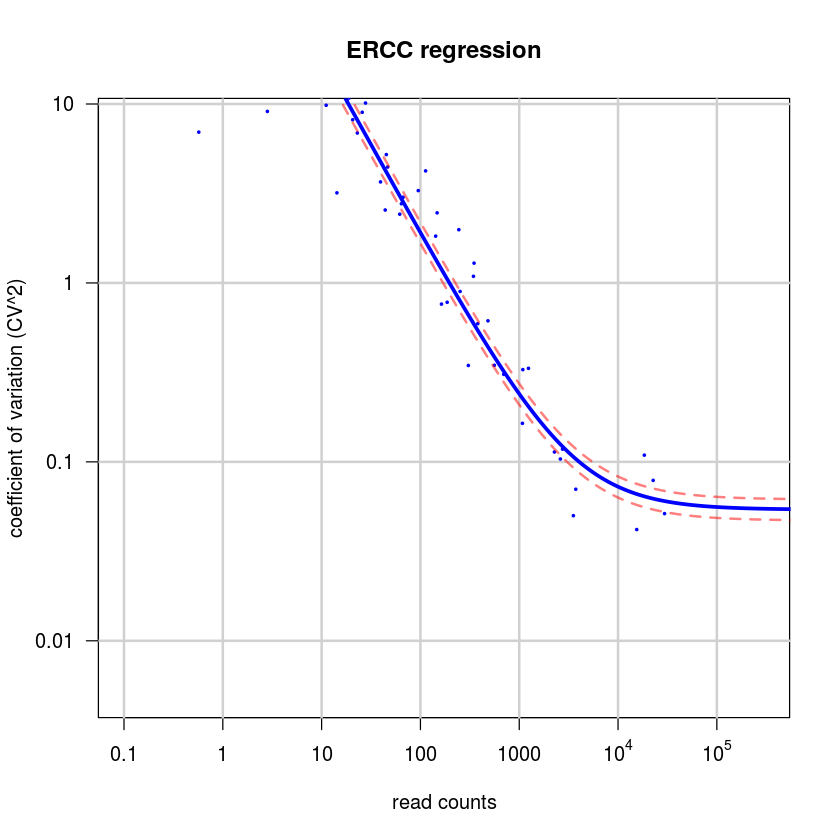

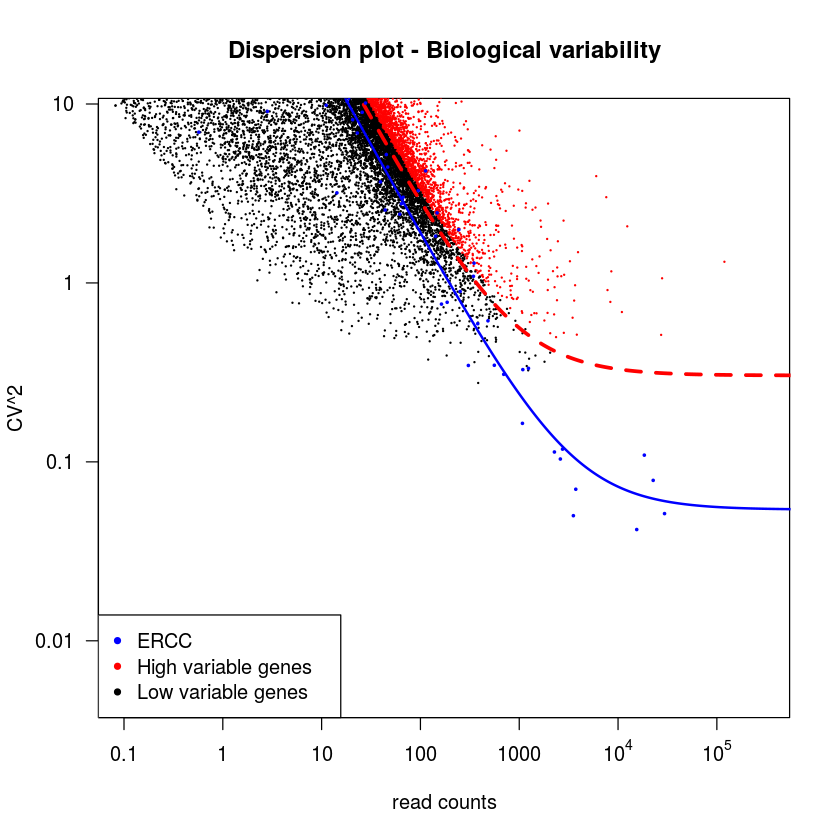

In [22]:
colERCC <- "#00207040"
colMmus <- "black"


meansMmus <- rowMeans( nCountsMmus )
varsMmus <- rowVars( nCountsMmus )
cv2Mmus <- varsMmus / meansMmus^2

meansERCC <- rowMeans( nCountsERCC )
varsERCC <- rowVars( nCountsERCC )
cv2ERCC <- varsERCC / meansERCC^2

minMeanForFitA <- unname( quantile( meansERCC[ which( cv2ERCC > .3 ) ], .95 ) )
minMeanForFitA
useForFitA <- meansERCC >= minMeanForFitA
fitA <- glmgam.fit( cbind( a0 = 1, a1tilde = 1/meansERCC[useForFitA] ),
                    cv2ERCC[useForFitA] )

fitA$coefficients


xi <- mean( 1 / sfERCC )
a0 <- unname( fitA$coefficients["a0"] )
a1 <- unname( fitA$coefficients["a1tilde"] - xi )
c( a0, a1 )

plot( NULL, xaxt="n", yaxt="n",
      log="xy", xlim = c( 1e-1, 3e5 ), ylim = c( .005, 8 ),
      xlab = "read counts", ylab = "coefficient of variation (CV^2)",main='ERCC regression' )
axis( 1, 10^(-1:5), c( "0.1", "1", "10", "100", "1000",
                       expression(10^4), expression(10^5) ) )
axis( 2, 10^(-2:1), c( "0.01", "0.1", "1", "10" ), las=2 )
abline( h=10^(-2:1), v=10^(-1:5), col="#D0D0D0", lwd=2 )

points( meansERCC, cv2ERCC, pch=20, cex=.4, col="blue" )

xg <- 10^seq( -2, 6, length.out=1000 )
lines( xg, (xi+a1)/xg + a0, col="blue", lwd=3 )

df <- ncol(countsMmus) - 1
lines( xg, ( (xi+a1)/xg + a0 ) * qchisq( .975, df ) / df,
       col="#FF000080", lwd=2, lty="dashed" )
lines( xg, ( (xi+a1)/xg + a0 ) * qchisq( .025, df ) / df,
       col="#FF000080", lwd=2, lty="dashed" ) 

psia1theta <- mean( 1 / sfMmus ) + a1 * mean( sfERCC / sfMmus )

minBiolDisp <- .5^2
m <- ncol(countsMmus)
cv2th <- a0 + minBiolDisp + a0 * minBiolDisp
testDenom <- ( meansMmus * psia1theta + meansMmus^2 * cv2th ) / ( 1 + cv2th/m )
p <- 1 - pchisq( varsMmus * (m-1) / testDenom, m-1 )

padj <- p.adjust( p, "BH" )
sig <- padj < .1
sig[is.na(sig)] <- FALSE
table( sig )

plot( NULL, xaxt="n", yaxt="n",
      log="xy", xlim = c( 1e-1, 3e5 ), ylim = c( .005, 8 ),
      main= 'Dispersion plot - Biological variability',
      xlab = "read counts", ylab = "CV^2" )
axis( 1, 10^(-1:5), c( "0.1", "1", "10", "100", "1000",
                       expression(10^4), expression(10^5) ) )
axis( 2, 10^(-2:1), c( "0.01", "0.1", "1", "10" ), las=2 )


points( meansMmus, cv2Mmus, pch=20, cex=.2,
        col = ifelse( padj < .1, "red", colMmus ) )

xg <- 10^seq( -2, 6, length.out=1000 )
lines( xg, (xi+a1)/xg + a0, col="blue", lwd=2 )

lines( xg, psia1theta/xg + a0 + minBiolDisp, lty="dashed", col="red", lwd=3 )
points( meansERCC, cv2ERCC, pch=20, cex=.4, col="blue" )

legend('bottomleft',c('ERCC','High variable genes','Low variable genes'),pch=20,col=c('blue','red','black'),cex=1)



In [16]:
## Create a table with the most significant biologically variable genes
log2RelExprMus <- log2( nCountsMmus + 1)
high.Var <- data.frame(
  row.names = NULL,
  ensembl_gene_id = rownames(countsMmus)[ sig ],
  meanNormCount = meansMmus[ sig ],
  log2RelExprMus[ sig, ],
  check.names=FALSE)

In [17]:
head(high.Var)

ensembl_gene_id,meanNormCount,P2272_1002,P2272_1004,P2272_1005,P2272_1006,P2272_1009,P2272_1010,P2272_1012,P2272_1013,⋯,P7657_1181,P7657_1182,P7657_1184,P7657_1185,P7657_1186,P7657_1187,P7657_1188,P7657_1190,P7657_1191,P7657_1192
ENSMUSG00000000001,120.03157,0.4001782,0.000000,0.5410561,9.6268420,0.2353862,0.000000,0.000000,0.000,⋯,0.000000,0.000000,7.222446,0.0000000,0.00000,0.000000,1.099182,7.1112922,0.00000,0.000000
ENSMUSG00000000031,395.52065,0.0000000,0.000000,0.2957449,0.2444772,0.0000000,0.000000,0.000000,0.000,⋯,0.000000,0.000000,0.000000,0.0000000,0.00000,0.000000,0.000000,0.0000000,0.00000,0.000000
ENSMUSG00000000056,35.20093,0.0000000,0.347601,4.8111995,0.0000000,3.5401897,2.194540,0.000000,0.000,⋯,0.000000,0.000000,0.000000,0.8720806,0.00000,0.000000,7.591798,0.0000000,0.00000,0.000000
ENSMUSG00000000058,97.65257,0.0000000,0.347601,0.0000000,0.0000000,6.7339913,2.194540,0.000000,0.000,⋯,0.000000,0.000000,8.939290,0.0000000,0.00000,0.000000,0.000000,0.0000000,10.01437,8.566506
ENSMUSG00000000078,2195.09250,1.8942175,12.449941,2.1416876,10.2835167,11.3679732,3.241194,3.667244,2.824,⋯,13.066587,4.423441,4.371945,11.3693288,11.00682,10.776724,7.998535,11.8135870,11.43179,7.903257
ENSMUSG00000000085,64.10177,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.000000,0.000000,0.000,⋯,4.806537,7.404949,0.000000,8.6659992,0.00000,9.187439,0.000000,0.9909679,0.00000,7.326044
